<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v1/blob/main/myProspects_200-50-20-DMA_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

Run date time (IST): 2024-08-20 20:10:51


In [2]:
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [3]:
import pandas as pd
import numpy as np
#from google.colab import drive
#drive.mount('/content/drive')

mypf = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myProspectsScrips.csv')

mypf = mypf[(mypf['Criteria'] == 'AV40') | (mypf['Criteria'] == 'AV40N')]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC','JIOFIN','SCHAEFFLER ','ADANITRANS', 'EQUITAS', 'MCDOWELL-N', 'ARE&M', 'UJJIVAN']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol'].unique()

stock_ids = stock_n100

#mypf = mypf[mypf.Forecast.notnull()]
#stock_ids = mypf['Symbol'].unique()

stock_ids.sort()
#stock_ids

In [4]:
# import necessary libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
import pandas_ta as ta

In [11]:
# function to compute stock attributes

def stock_prec_dev(stock_symbol, date):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    end_date = date.strftime('%Y-%m-%d')
    start_date = (date + datetime.timedelta(days=-365*3)).strftime('%Y-%m-%d')
    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    #start = datetime.datetime(*map(int, start_date.split('-')))
    #end = datetime.datetime(*map(int, end_date.split('-')))
    stock_df = yfin.Ticker(stock_symbol).history(period='2y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    #stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe
    #stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg

    #print(stock_df)

    # Create short exponential moving average column
    stock_df[short_window_col] = round(stock_df['Close'].rolling(window = short_window, min_periods = 1).mean(),0)

    stock_df[mid_window_col] = round(stock_df['Close'].rolling(window = mid_window, min_periods = 1).mean(),0)

    #stock_df['RSI'] = round(talib.RSI(stock_df['Close Price'], timeperiod=14),0)

    # Create a long exponential moving average column
    stock_df[long_window_col] = round(stock_df['Close'].rolling(window = long_window, min_periods = 1).mean(),0)
    stock_df['Stock'] = stock_symbol
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df['Close'] = round(stock_df['Close'],0)
    stock_df.drop(['Open', 'Low', 'High', 'Volume'
                   ], axis=1, inplace=True)

    return stock_df

def get_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal'])

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal'])

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)

    return df_pos.tail(1)

def get_daily_buy_sell(stock_ids):
    df_buy_sell = pd.DataFrame()
    print(stock_ids)
    for stock_id in stock_ids:
        print(stock_id)
        df_tmp = get_stock_buy_sell(stock_id+'.NS')
        df_tmp['Criteria'] = mypf[(mypf['Symbol']) == stock_id.upper()]['Criteria'].values[0]
        df_buy_sell = pd.concat([df_buy_sell, df_tmp], ignore_index=True)


    df_buy_sell['Position'] = df_buy_sell['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
    return df_buy_sell.sort_index()

def plot_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal'])

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal'])

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df_prec_dev['Close'].plot(color = 'k', lw = 1, label = 'Close')
    #stock_df[short_window_col].plot(color = 'g', lw = 1, label = short_window_col)
    df_prec_dev['20_SMA'].plot(color = 'g', lw = 1, label = '20_SMA')
    df_prec_dev['50_SMA'].plot(color = 'm', lw = 1, label = '50_SMA')
    df_prec_dev['200_SMA'].plot(color = 'b', lw = 1, label = '200_SMA')

    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)


    # plot 'buy' signals
    plt.plot(df_pos[df_pos['Position'] >= 1].index,
          df_pos['Close'][df_pos['Position'] >= 1],
          '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df_pos[df_pos['Position'] <= -1].index,
          df_pos['Close'][df_pos['Position'] <= -1],
          'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')

    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(stock_symbol + '  : Buy/Sell Signal', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

    display_table = True

    if display_table == True:
      print(stock_symbol)
      df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
      print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

df_daily_buy_sell = get_daily_buy_sell(stock_ids)

['3MINDIA' '5PAISA' 'ABBOTINDIA' 'AKZOINDIA' 'ANGELONE' 'ASIANPAINT'
 'ASTRAZEN' 'AXISBANK' 'BAJAJ-AUTO' 'BAJAJFINSV' 'BAJAJHLDNG' 'BAJFINANCE'
 'BATAINDIA' 'BAYERCROP' 'BOSCHLTD' 'CAPLIPOINT' 'CERA' 'COLPAL' 'DABUR'
 'DIXON' 'EICHERMOT' 'EQUITASBNK' 'ERIS' 'FINCABLES' 'FINEORG' 'GILLETTE'
 'GLAXO' 'HAVELLS' 'HCLTECH' 'HDFCAMC' 'HDFCBANK' 'HDFCLIFE' 'HINDUNILVR'
 'HONAUT' 'ICICIBANK' 'ICICIGI' 'ICICIPRULI' 'INDIGOPNTS' 'INFY' 'ISEC'
 'ITC' 'JCHAC' 'KANSAINER' 'KOTAKBANK' 'LALPATHLAB' 'LUXIND' 'MARICO'
 'MCX' 'MOTILALOFS' 'NAM-INDIA' 'NESTLEIND' 'OFSS' 'PAGEIND' 'PFIZER'
 'PGHH' 'PIDILITIND' 'POLYCAB' 'RADICO' 'RAJESHEXPO' 'RELAXO' 'RELIANCE'
 'SANOFI' 'SIS' 'SUNTV' 'SYMPHONY' 'TATAELXSI' 'TCS' 'TEAMLEASE' 'TITAN'
 'TTKPRESTIG' 'UJJIVANSFB' 'VINATIORGA' 'VIPIND' 'WHIRLPOOL']
3MINDIA
5PAISA
ABBOTINDIA
AKZOINDIA
ANGELONE
ASIANPAINT
ASTRAZEN
AXISBANK
BAJAJ-AUTO
BAJAJFINSV
BAJAJHLDNG
BAJFINANCE
BATAINDIA
BAYERCROP
BOSCHLTD
CAPLIPOINT
CERA
COLPAL
DABUR
DIXON
EICHERMOT
EQUITASBNK
ERIS
FINCABL

In [12]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Sell'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position,Criteria
45,1476.0,1472.0,1379.0,1341.0,LUXIND.NS,10.07,-1.0,Sell,AV40N
46,597.0,585.0,537.0,535.0,MARICO.NS,11.64,-1.0,Sell,AV40
47,1487.0,1373.0,1293.0,1292.0,MCX.NS,15.06,-1.0,Sell,AV40N
49,278.0,246.0,234.0,233.0,NAM-INDIA.NS,19.21,-1.0,Sell,AV40
50,2170.0,2044.0,1924.0,1920.0,NESTLEIND.NS,13.02,-1.0,Sell,AV40
51,2834.0,2790.0,2786.0,2776.0,OFSS.NS,2.09,-1.0,Sell,AV40N
52,39119.0,38841.0,36761.0,36726.0,PAGEIND.NS,6.52,-1.0,Sell,AV40
53,3943.0,3877.0,3873.0,3847.0,PFIZER.NS,2.51,-1.0,Sell,AV40
54,17018.0,16981.0,16710.0,16694.0,PGHH.NS,1.94,-1.0,Sell,AV40
55,2701.0,2607.0,2496.0,2495.0,PIDILITIND.NS,8.27,-1.0,Sell,AV40


In [13]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Buy'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position,Criteria
1,496.0,514.0,520.0,522.0,5PAISA.NS,-4.91,1.0,Buy,AV40N
4,2353.0,2559.0,2613.0,2747.0,ANGELONE.NS,-14.33,1.0,Buy,AV40N
5,2948.0,2983.0,3158.0,3162.0,ASIANPAINT.NS,-6.77,1.0,Buy,AV40
9,1551.0,1585.0,1587.0,1610.0,BAJAJFINSV.NS,-3.66,1.0,Buy,AV40
11,6571.0,6909.0,7208.0,7214.0,BAJFINANCE.NS,-8.92,1.0,Buy,AV40
21,93.0,94.0,95.0,96.0,EQUITASBNK.NS,-2.66,1.0,Buy,AV40N
37,1448.0,1452.0,1464.0,1469.0,INDIGOPNTS.NS,-1.45,1.0,Buy,AV40N
42,267.0,291.0,315.0,316.0,KANSAINER.NS,-15.56,1.0,Buy,AV40N
43,1754.0,1785.0,1819.0,1822.0,KOTAKBANK.NS,-3.74,1.0,Buy,AV40
48,439.0,440.0,665.0,797.0,MOTILALOFS.NS,-44.94,1.0,Buy,AV40N


In [ ]:
tmp_df = df_daily_buy_sell.reset_index()
#tmp_df.to_csv('/content/drive/My Drive/data/stocks/myProspects-Buy-Sell-Signals.csv', index=False)

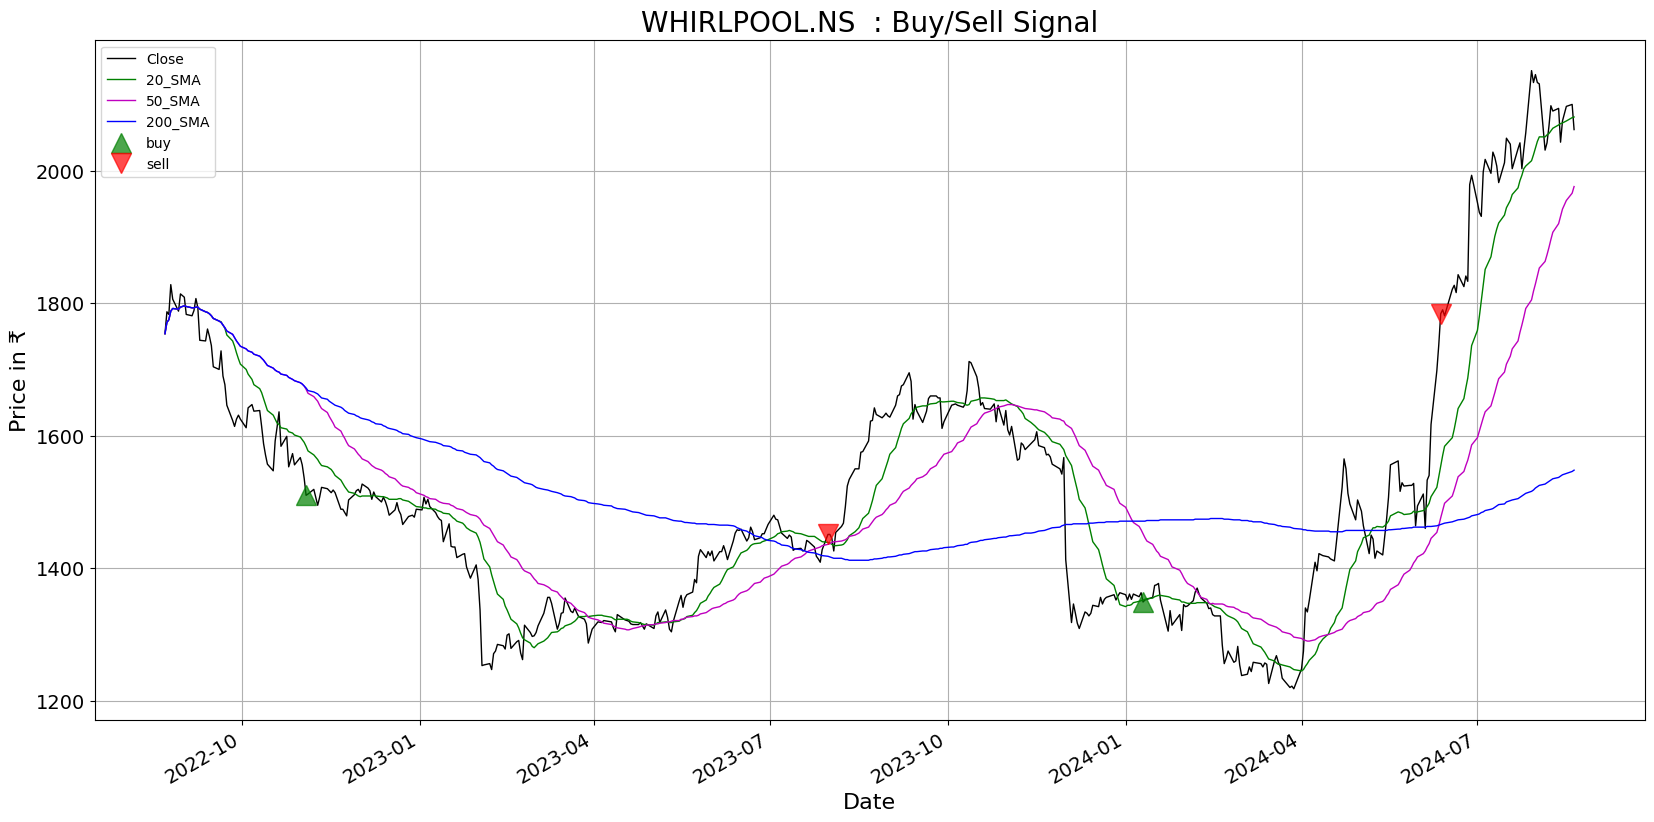

WHIRLPOOL.NS
+---------------------------+---------+----------+----------+-----------+--------------+------------+----------+------------+
| Date                      |   Close |   20_SMA |   50_SMA |   200_SMA | Stock        |   Dev%_200 |   Signal | Position   |
|---------------------------+---------+----------+----------+-----------+--------------+------------+----------+------------|
| 2022-11-03 00:00:00+05:30 |    1510 |     1584 |     1670 |      1672 | WHIRLPOOL.NS |      -9.66 |        1 | Buy        |
| 2023-07-31 00:00:00+05:30 |    1451 |     1439 |     1436 |      1418 | WHIRLPOOL.NS |       2.33 |       -1 | Sell       |
| 2024-01-10 00:00:00+05:30 |    1349 |     1352 |     1452 |      1471 | WHIRLPOOL.NS |      -8.3  |        1 | Buy        |
| 2024-06-12 00:00:00+05:30 |    1784 |     1554 |     1476 |      1466 | WHIRLPOOL.NS |      21.7  |       -1 | Sell       |
+---------------------------+---------+----------+----------+-----------+--------------+------------+----

In [15]:
stock_symbol = 'WHIRLPOOL.NS'
plot_stock_buy_sell(stock_symbol)